In [39]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

# Standard model performance

# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


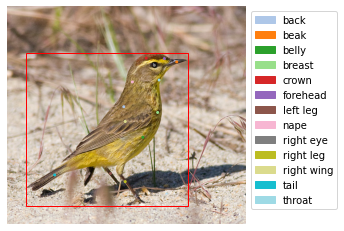

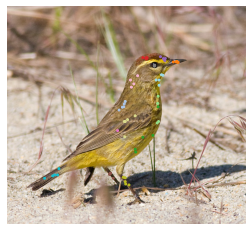

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


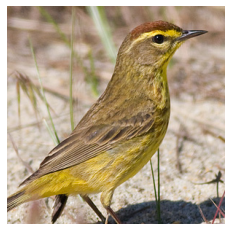

In [95]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = CUB_train_transform(Subset(cub, train_indices))
cub_test = CUB_test_transform(Subset(cub, test_indices))

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()
    
show_cub_data(cub_test, 30)

In [96]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(SubColumn(cub_train, ['x', 'y']), batch_size=32, shuffle=True, num_workers=8)
loader_xy_te = DataLoader(SubColumn(cub_test, ['x', 'y']), batch_size=32, shuffle=False, num_workers=8)

image size: torch.Size([3, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


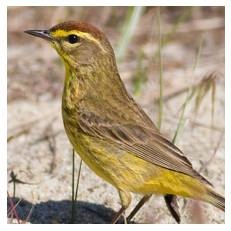

image size: torch.Size([3, 200, 200])
0-indexed class id (describe bird is 1-indexed): 173


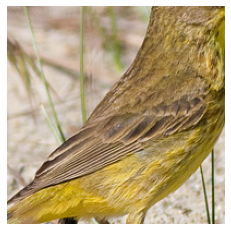

image size: torch.Size([1, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


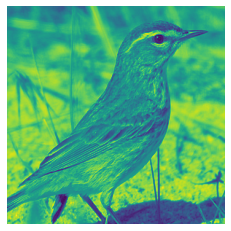

image size: torch.Size([3, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


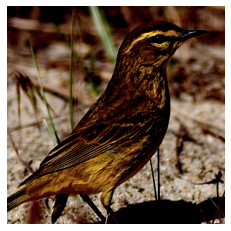

image size: torch.Size([3, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


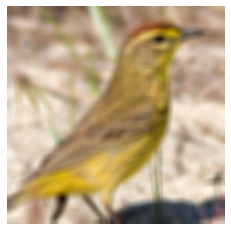

image size: torch.Size([3, 200, 200])
0-indexed class id (describe bird is 1-indexed): 173


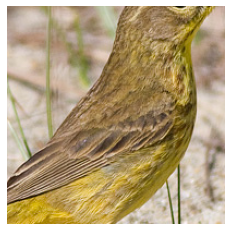

In [97]:
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

def show_transform(dataset, idx, transform=lambda x: x):
    im, y = dataset[idx]['x'], dataset[idx]['y'] 
    im = transform(im)
    print('image size:',  im.shape)    
    im = im.permute(1,2,0)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()


show_transform(cub_test, 30, transform=lambda x: RandomHorizontalFlip(1)(x))
show_transform(cub_test, 30, transform=lambda x: RandomCrop(200)(x))
show_transform(cub_test, 30, transform=lambda x: Grayscale()(x))
show_transform(cub_test, 30, transform=lambda x: ColorJitter(brightness=32/255, saturation=(0.5, 1.5))(x))
show_transform(cub_test, 30, transform=lambda x: GaussianBlur(11, (10,20))(x))
show_transform(cub_test, 30, transform=lambda x: CenterCrop(200)(x))


Text(0, 0.5, 'accuracy')

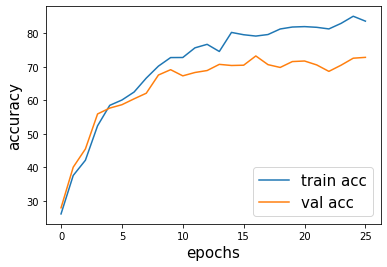

In [59]:
plot_log(torch.load('../models/standard.log'), key='train acc')
plot_log(torch.load('../models/standard.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

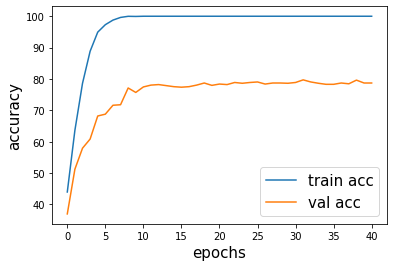

In [76]:
plot_log(torch.load('../models/standard_imagenet.log'), key='train acc')
plot_log(torch.load('../models/standard_imagenet.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

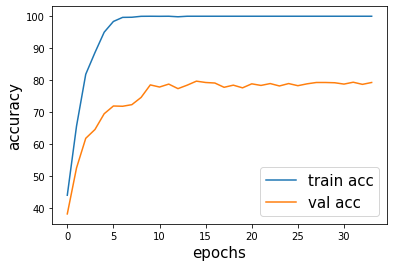

In [75]:
plot_log(torch.load('../models/standard_same.log'), key='train acc')
plot_log(torch.load('../models/standard_same.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

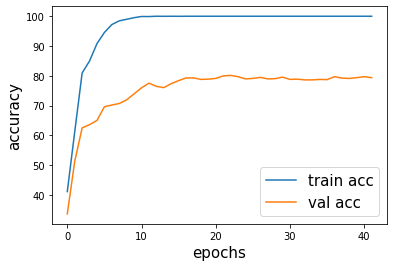

In [77]:
plot_log(torch.load('../models/standard_flip.log'), key='train acc')
plot_log(torch.load('../models/standard_flip.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

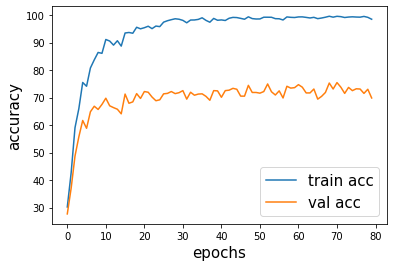

In [80]:
plot_log(torch.load('../models/standard_cbm.log'), key='train acc')
plot_log(torch.load('../models/standard_cbm.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'loss')

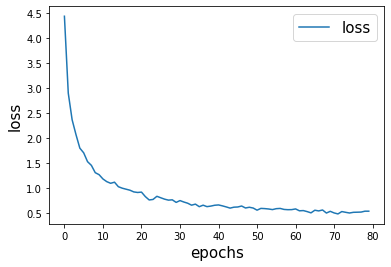

In [82]:
plot_log(torch.load('../models/standard_cbm.log'), key='loss')
# plot_log(torch.load('../models/standard_cbm.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('loss', fontsize=15)

(70.0, 81.0)

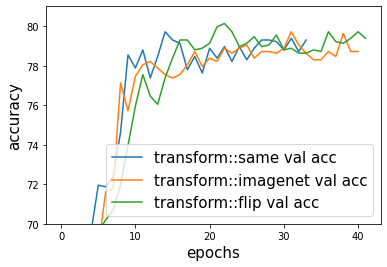

In [79]:
plot_log(torch.load('../models/standard_same.log'), key='val acc', ylabel='transform::same val acc')
plot_log(torch.load('../models/standard_imagenet.log'), key='val acc', ylabel='transform::imagenet val acc')
plot_log(torch.load('../models/standard_flip.log'), key='val acc', ylabel='transform::flip val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([70, 81])

(70.0, 81.0)

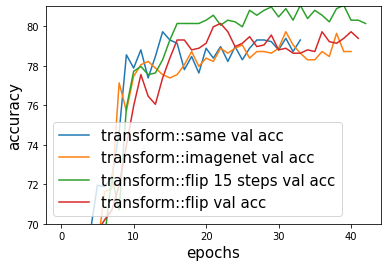

In [87]:
plot_log(torch.load('../model_backup/standard_same.log'), key='val acc', ylabel='transform::same val acc')
plot_log(torch.load('../model_backup/standard_imagenet.log'), key='val acc', ylabel='transform::imagenet val acc')
plot_log(torch.load('../models/standard_flip.log'), key='val acc', ylabel='transform::flip 15 steps val acc')
plot_log(torch.load('../model_backup/standard_flip.log'), key='val acc', ylabel='transform::flip val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([70, 81])

(70.0, 82.0)

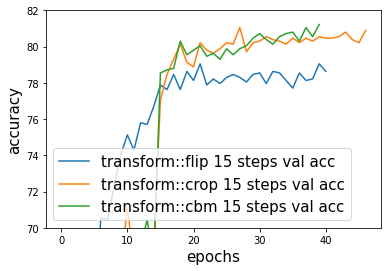

In [99]:
plot_log(torch.load('../models/standard_flip.log'), key='val acc', ylabel='transform::flip 15 steps val acc')
plot_log(torch.load('../models/standard_crop.log'), key='val acc', ylabel='transform::crop 15 steps val acc')
plot_log(torch.load('../models/standard_cbm.log'), key='val acc', ylabel='transform::cbm 15 steps val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([70, 82])